In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import pandas as pd
import torch
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pytorch_lightning as pl

import opf
import opf.utils
import opf.dataset
import utils
import tqdm
from glob import glob
import guild.ipy as guild

mpl.rcParams["text.usetex"] = False

sns.set_style("white")
sns.set_context("paper")

In [3]:
# case30 821616dec5e84704be798ba373f9780b
# case57 4eb98391a7304ea394ce9bf450044ca8
# case118 447df0095d924a2591563368bd088ee8
run_id = "4eb98391a7304ea394ce9bf450044ca8"
run_dir = f"{guild.guild_home()}/runs/{run_id}/tensorboard/{run_id}"

In [4]:
api = wandb.Api()
run = api.run(f"damowerko/opf/{run_id}")
print(run.config)

run.config.update(data_dir="../data")
dm = opf.dataset.CaseDataModule(**run.config)
barrier = utils.create_model(dm, run.config).cpu()

# load checkpoint
checkpoints = glob(f"{run_dir}/*.ckpt")
checkpoint = torch.load(checkpoints[0], map_location="cpu")
barrier.load_state_dict(checkpoint["state_dict"], strict=True)


save_dir = f"/home/damow/Dropbox/Apps/Overleaf/Unsupervised Optimal Power Flow Using Graph Neural Networks/figures/{run.config['case_name']}/"
os.makedirs(save_dir, exist_ok=True)
def save(title: str, fig=plt):
    fig.savefig(save_dir + f"{title}.png")
    fig.savefig(save_dir + f"{title}.pdf")



{'F': 32, 'K': 8, 'L': 2, 's': 10, 't': 500, 'lr': 0.0003, 'eps': 0.0001, 'log': 1, 'gpus': 1, 'wandb': 1, 'log_dir': '.', 'readout': 'local', 'data_dir': 'data/', 'hotstart': 'None', 'patience': 50, 'root_dir': '/home/damow/projects/opf/scripts/./', 'case_name': 'case57', 'activation': 'leaky_relu', 'batch_size': 256, 'max_epochs': 10000, 'cost_weight': 0.01, 'fast_dev_run': False, 'adj_threshold': 0.01, 'gradient_clip_val': 0, 'constraint_features': 1, 'enforce_constraints': 0}


/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [5]:
# Run test
barrier.detailed_metrics = True
outputs = utils.test(barrier, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1579: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

# Summary

In [6]:
df = outputs.copy()
display(df[[
    "test/equality/error_max",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]].max())

print(f"""
GNN Cost: {df["test/cost"].mean():0.4f}
IPOPT Cost: {df["acopf/cost"].mean():0.4f}
GNN/IPOPT: {(df["test/cost"]/df["acopf/cost"]).mean():0.4f}
Maximum violation rate: {df["test/inequality/rate"].max():0.4f}
Rate of any violation: {(df["test/inequality/error_max"] > 1e-4).sum() / len(df):0.4f}
""")


test/equality/error_max                               0.000000
test/inequality/error_max                             4.006525
test/inequality/active_power/error_max                0.404081
test/inequality/reactive_power/error_max              4.006525
test/inequality/voltage_magnitude/error_max           0.145643
test/inequality/forward_rate/error_max                0.000000
test/inequality/backward_rate/error_max               0.000000
test/inequality/voltage_angle_difference/error_max    0.000000
dtype: float64


GNN Cost: 133.8246
IPOPT Cost: 126.9659
GNN/IPOPT: 1.0539
Maximum violation rate: 0.0134
Rate of any violation: 1.0000



# Histograms


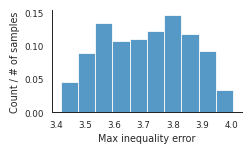
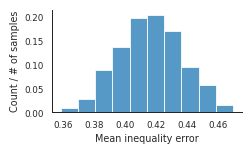
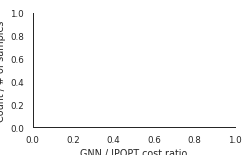
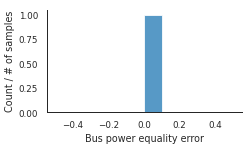
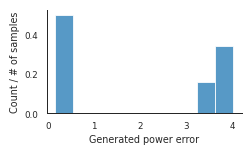
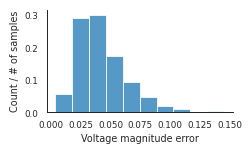
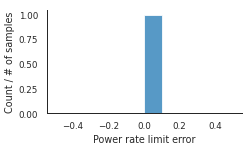
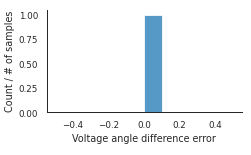

In [7]:
from utils import FlowLayout
aspect = 1.618
kwargs = dict(
    bins=10,
    stat="proportion",
    aspect=aspect,
    height=3.5/aspect,
)

ylabel = "Count / # of samples"

sns.displot(df, x="test/inequality/error_max", **kwargs)
plt.xlabel("Max inequality error")
plt.ylabel(ylabel)
save("error_max")

sns.displot(df, x="test/inequality/error_mean", **kwargs)
plt.xlabel("Mean inequality error")
plt.ylabel(ylabel)
save("error_mean")

# Cost improvement
df["test/cost/improvement"] = df["test/cost"]/df["acopf/cost"]
df["violation"] = df["test/inequality/rate"] > 1e-8
sns.displot(df[~df["violation"]], x="test/cost/improvement", **kwargs)
plt.xlabel("GNN / IPOPT cost ratio")
plt.ylabel(ylabel)
save("costs")

# map variable names to series names
fmt = "test/inequality/%s/error_max"

hist_dict = {
    "equality": ["test/equality/bus_power/error_max"],
    "gen": [fmt % "active_power", fmt % "reactive_power"],
    "vm": [fmt % "voltage_magnitude"],
    "rate": [fmt % "forward_rate", fmt % "backward_rate"],
    "vad": [fmt % "voltage_angle_difference"]
}

sns.displot(df["test/equality/bus_power/error_max"], **kwargs)
plt.xlabel("Bus power equality error")
plt.ylabel(ylabel)
save("error_equality")

power_df = df.melt(value_vars=[fmt % "active_power", fmt % "reactive_power"])
sns.displot(power_df, x="value", **kwargs)
plt.xlabel("Generated power error")
plt.ylabel(ylabel)
save("error_gen")

sns.displot(df[fmt % "voltage_magnitude"], **kwargs)
plt.xlabel("Voltage magnitude error")
plt.ylabel(ylabel)
save("error_vm")

flow_df = df.melt(value_vars=[fmt % "forward_rate", fmt % "backward_rate"])
sns.displot(flow_df, x="value", **kwargs)
plt.xlabel("Power rate limit error")
plt.ylabel(ylabel)
save("error_rate")

sns.displot(df[fmt % "voltage_angle_difference"], **kwargs)
plt.xlabel("Voltage angle difference error")
plt.ylabel(ylabel)
save("error_vad")

FlowLayout().all_open()

# Visualizing Violations

In [8]:
sort_term = "test/inequality/error_max"
quantile = 1

s = df[sort_term]
index = (s.sort_values()[::-1] <= s.quantile(quantile)).idxmax()
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][[
    "test/cost",
    "test/equality/bus_power/error_max",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]]

test/inequality/error_max 4.006524880374246
Idx 393


test/cost                                             128.007251
test/equality/bus_power/error_max                            0.0
test/inequality/error_max                               4.006525
test/inequality/active_power/error_max                  0.328728
test/inequality/reactive_power/error_max                4.006525
test/inequality/voltage_magnitude/error_max              0.04952
test/inequality/forward_rate/error_max                       0.0
test/inequality/backward_rate/error_max                      0.0
test/inequality/voltage_angle_difference/error_max           0.0
Name: 393, dtype: object

/home/damow/.pyenv/versions/3.9.5/envs/opf/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


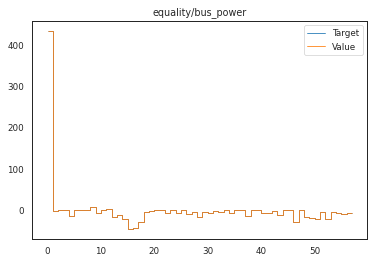

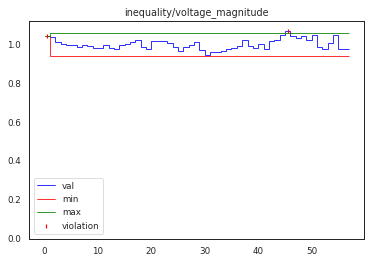

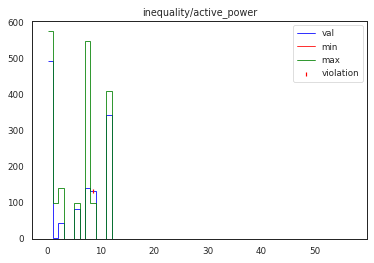

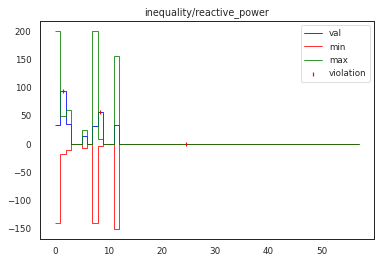

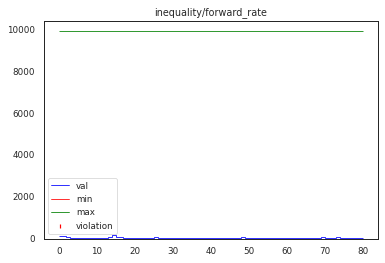

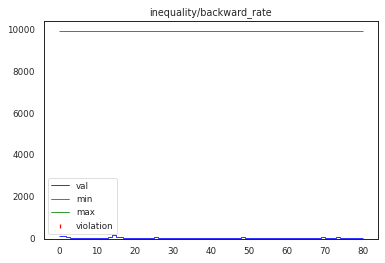

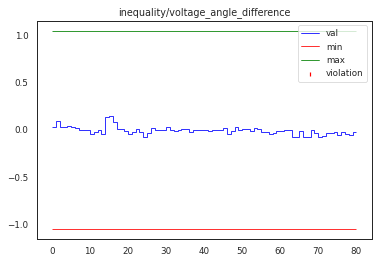

In [9]:
import opf.plot

dataset = list(dm.test_dataloader())
barrier.double()
load = dataset[index][0].double() @ barrier.powerflow_parameters.load_matrix
with torch.no_grad():
    variables, _, _, _ = barrier._step_helper(*barrier(load), True)
plots = opf.plot.plot_constraints(variables, barrier.powerflow_parameters)

In [10]:
# df["acopf/cost/relaxed"] = None
# for i in tqdm.tqdm(range(len(df))):
#     forward_error = df.iloc[i]["test/inequality/forward_rate/error_max"]
#     backward_error = df.iloc[i]["test/inequality/backward_rate/error_max"]

#     increase = 1 + torch.clamp((torch.maximum(variables.Sf.abs(), variables.St.abs()) - barrier.powerflow_parameters.rate_a) / barrier.powerflow_parameters.rate_a, min=0) \
#         .squeeze().detach().numpy()
#     net = barrier.net_wrapper.net
#     original = net.line.copy()
#     barrier.net_wrapper.set_load_sparse(variables.Sd.real.squeeze(), variables.Sd.imag.squeeze())

#     net.line["max_i_ka"] *= increase[:len(net.line)]
#     bus = torch.as_tensor(barrier.net_wrapper.optimal_ac(False)[0]).double().unsqueeze(0)
#     _, constraints, cost, _ = barrier._step_helper(
#                     *barrier.parse_bus(bus),
#                     variables.Sd,
#                     project_pandapower=False,
#     )
#     net.line = original
#     df["acopf/cost/relaxed"].iloc[i] = cost.item()
# print("IPOPT Original Cost:", df["acopf/cost"].mean())
# print("IPOPT Relaxed Cost:", df["acopf/cost/relaxed"].mean())
# print("GNN Cost", df["test/cost"].mean())